In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

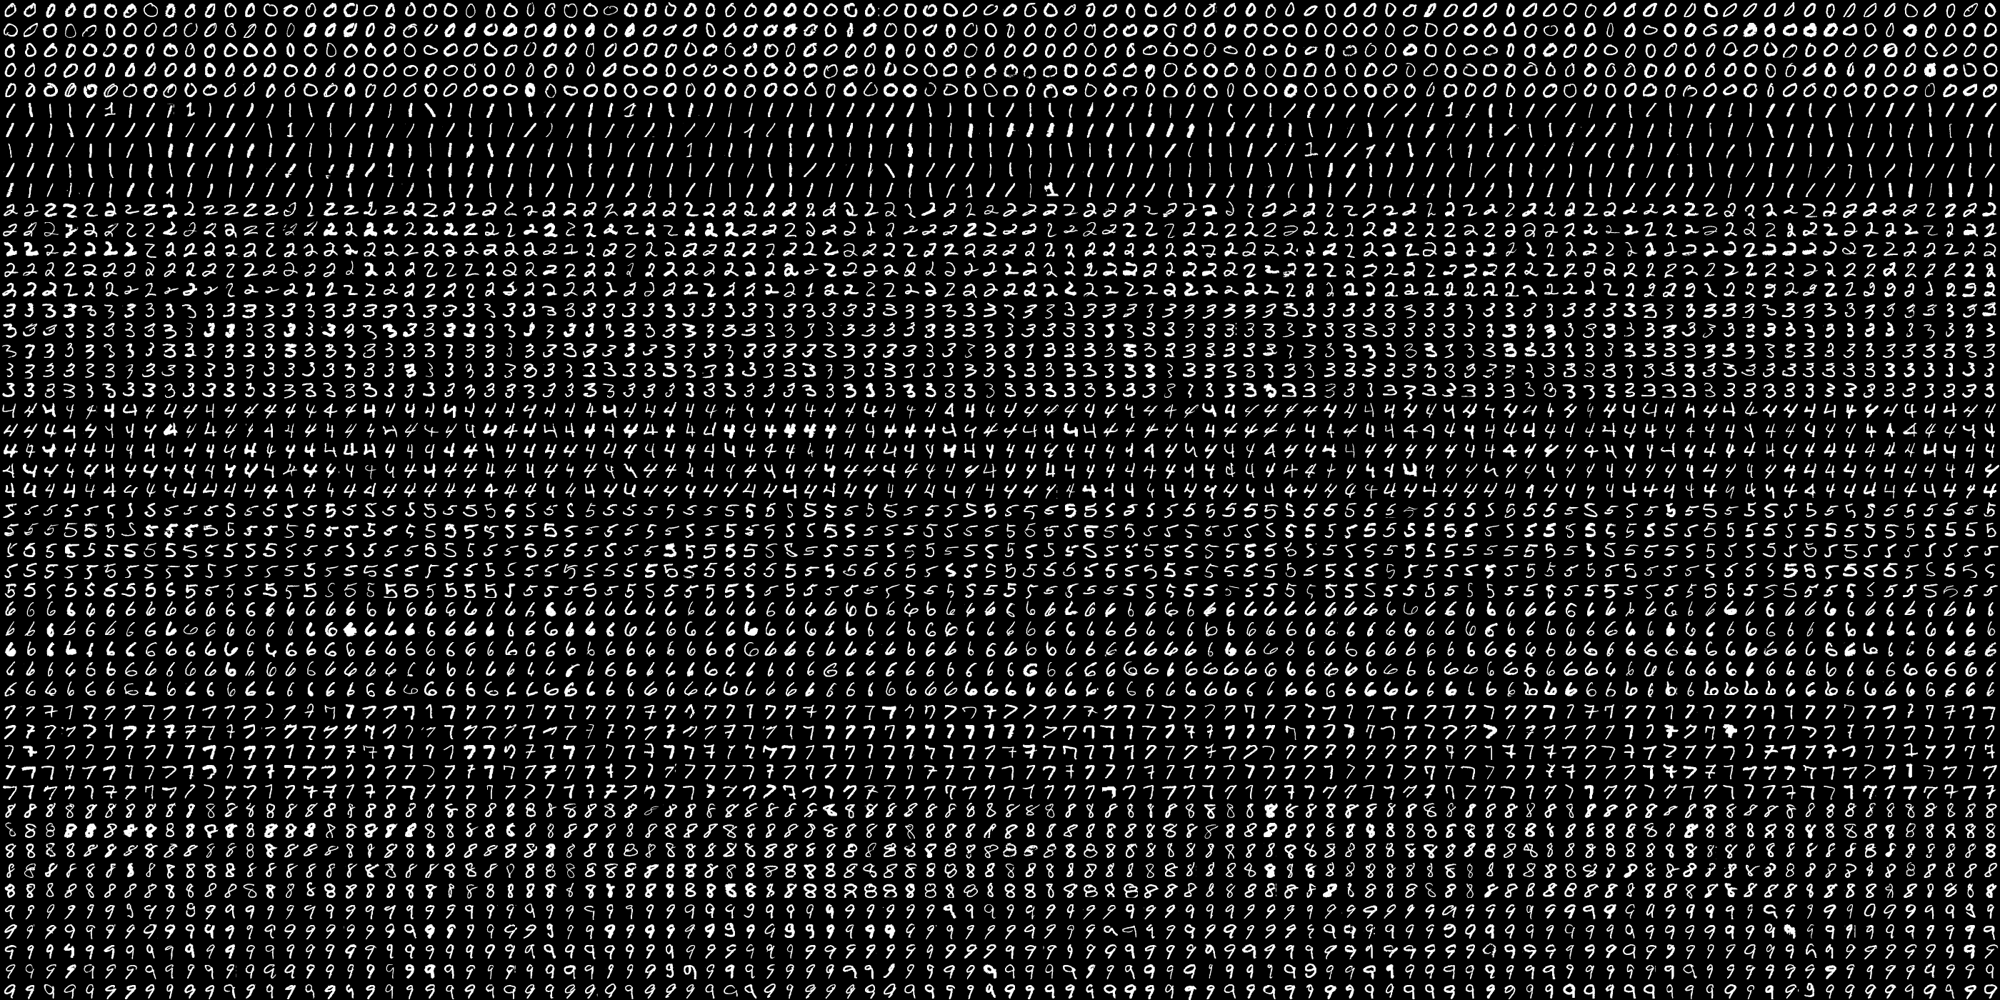

In [ ]:
img = cv2.imread('./digits.png')
cv2_imshow(img)

#data preparation

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Define rotation angles
angles = [-10, -5, 5, 10]

# Function to apply augmentations
def augment_image(image, angles):
    rows, cols = image.shape
    augmented_images = []

    for angle in angles:
        # Rotate the image
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(image, M, (cols, rows))

        # Translate the image
        tx = np.random.uniform(-1, 1)
        ty = np.random.uniform(-1, 1)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        translated = cv2.warpAffine(rotated, M, (cols, rows))

        # Add random noise
        noise = np.random.randn(rows, cols) * 5
        noisy = translated + noise
        noisy = np.clip(noisy, 0, 255)

        augmented_images.append(noisy.astype(np.uint8))

    return augmented_images

# Load the digits image
img = cv2.imread('./digits.png')

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image . Please check the file path.")
else:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Split the image into 5000 cells, each 20x20 size
    cells = [np.hsplit(row, 100) for row in np.vsplit(gray, 50)]
    x = np.array(cells)

    # Prepare train_data and test_data
    train = x[:, :50].reshape(-1, 400).astype(np.float32)
    test = x[:, 50:100].reshape(-1, 400).astype(np.float32)

    # Apply data augmentation to training data
    augmented_train = []
    for img in train:
        img_reshaped = img.reshape(20, 20)
        augmented_images = augment_image(img_reshaped, angles)
        for aug_img in augmented_images:
            augmented_train.append(aug_img.reshape(-1))
    augmented_train = np.array(augmented_train, dtype=np.float32)

    # Create labels for train and test data
    k = np.arange(10)
    train_labels = np.repeat(k, 250)[:, np.newaxis]
    augmented_train_labels = np.repeat(train_labels, len(angles), axis=0)  # Repeat labels for augmented data

    test_labels = train_labels.copy()

#model training

In [ ]:
# Train kNN
knn = cv2.ml.KNearest_create()
knn.train(augmented_train, cv2.ml.ROW_SAMPLE, augmented_train_labels)

True

#model evaluation

In [ ]:
ret, results, neighbours, dist = knn.findNearest(test, k=5)

In [ ]:
# Check accuracy
matches = results == test_labels
correct = np.count_nonzero(matches)
accuracy = correct * 100.0 / results.size
print(f'Accuracy: {accuracy}%')

# Save the trained data
np.savez('knn_data.npz', train=augmented_train, train_labels=augmented_train_labels)

Accuracy: 94.2%


In [ ]:
# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, results, average='weighted')
recall = recall_score(test_labels, results, average='weighted')
f1 = f1_score(test_labels, results, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.94
Recall: 0.94
F1 Score: 0.94


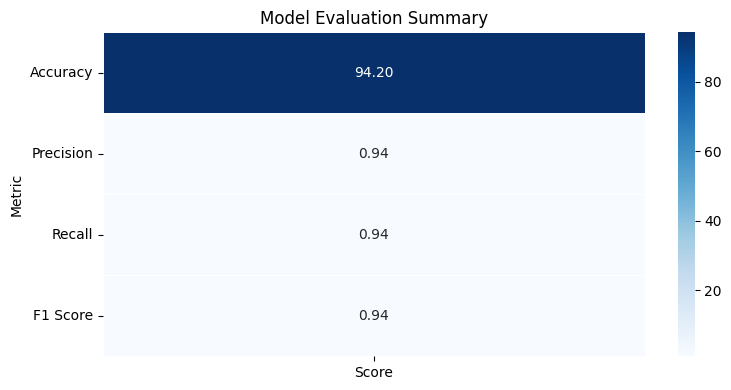

In [ ]:
# Create a DataFrame for the summary
summary_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
}

df_summary = pd.DataFrame(summary_data).set_index('Metric')
import seaborn as sns
# Create a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_summary, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)

# Set title and labels
plt.title('Model Evaluation Summary')
plt.yticks(rotation=0)  # Rotate y-axis labels to be horizontal

# Display the plot
plt.tight_layout()
plt.show()

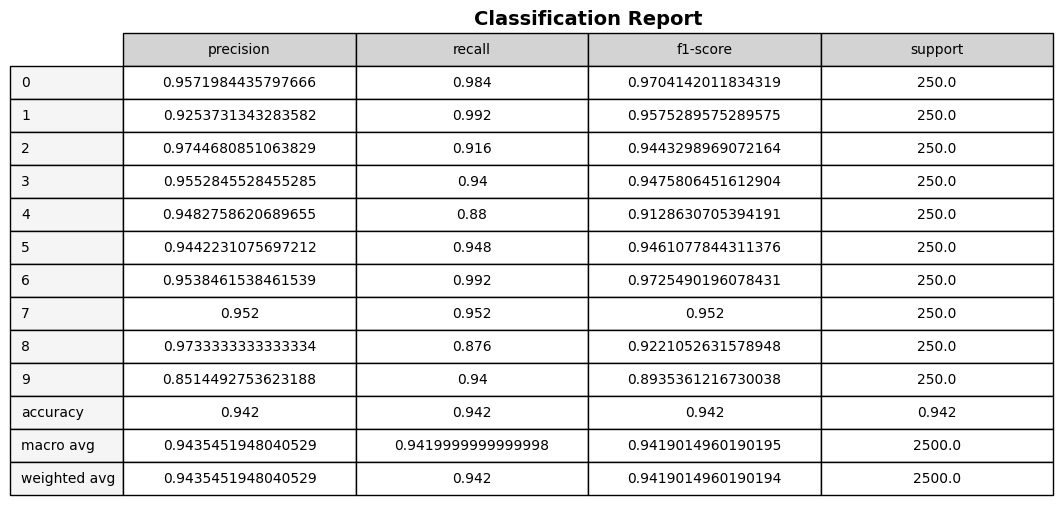

In [ ]:
report = classification_report(test_labels, results, output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figsize as needed
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=report_df.values,
                 colLabels=report_df.columns,
                 rowLabels=report_df.index,
                 cellLoc='center',
                 loc='center',
                 rowColours=['#f5f5f5']*(len(report_df)),
                 colColours=['#d3d3d3']*len(report_df.columns),
                 bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the table size

# Add title
plt.title('Classification Report', fontsize=14, weight='bold')

# Display the plot
plt.show()

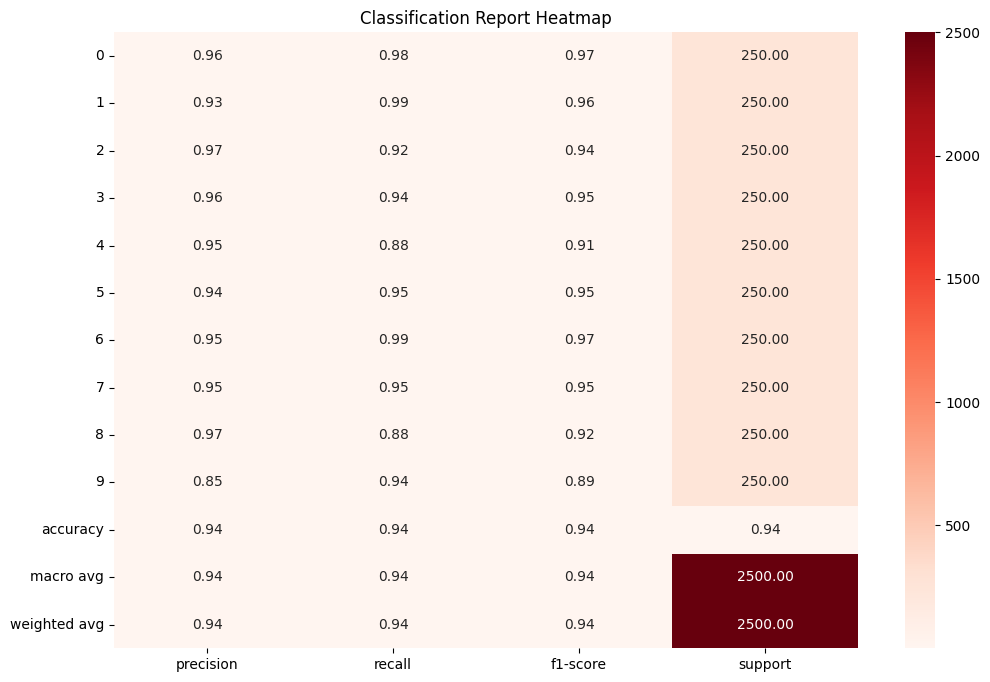

In [ ]:
# Visualiser le rapport de classification en heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_df[['precision', 'recall', 'f1-score', 'support']], annot=True, fmt='.2f', cmap='Reds', cbar=True)
plt.title('Classification Report Heatmap')
plt.show()

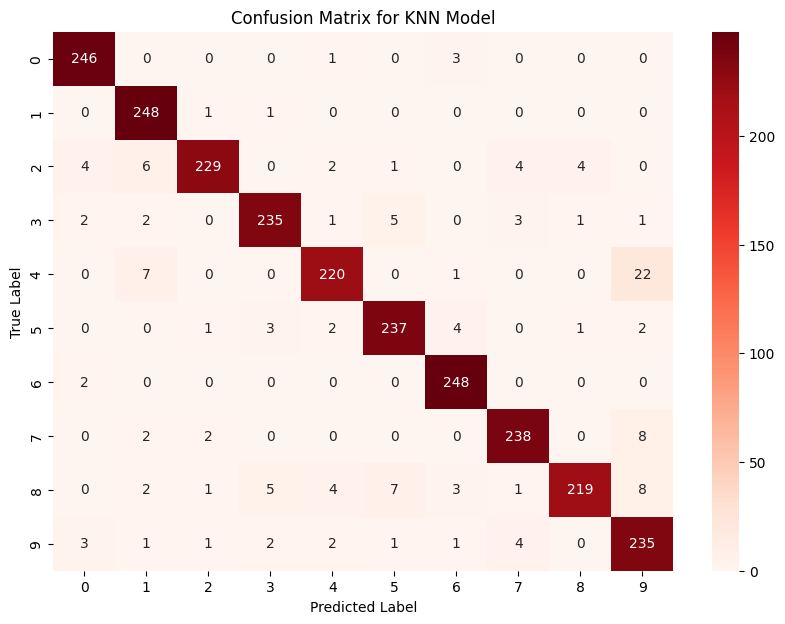

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_labels, results)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=k, yticklabels=k)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN Model')
plt.show()